In [ ]:
!pip install datasets
!pip install evaluate
!pip install fsspec==2023.9.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have 

## Imports

In [ ]:
import numpy as np
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Add your imports here

# 🔍Detección de profesiones en tweets

## Enunciado

En este ejercicio vamos a trabajar con un conjunto de datos procedente de medios sociales online.

Utilizaremos un subconjunto de los datos de la tarea 1 del shared task [**ProfNER**](https://temu.bsc.es/smm4h-spanish), centrada en la detección de menciones a profesiones en tweets publicados durante la pandemia del COVID-19. El objetivo original de la tarea era analizar que profesiones podrían haber sido especialmente vulnerables en el contexto de la crisis sanitaria.

 La tarea será entrenar un clasificador binario basado en la arquitectura Transformers, que, dado un tweet, determine si contiene una mención explícita a una profesión (etiqueta `1`) o no (etiqueta `0`).




## Obtención de datos

Descargamos los datos del [repositorio de Huggingface](https://huggingface.co/datasets/luisgasco/profner_classification_master).

In [ ]:
#NO-MODIFY: DATA LOAD
from datasets import load_dataset, Dataset, DatasetDict, ClassLabel
dataset = load_dataset("luisgasco/profner_classification_master")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/480k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/162k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/166k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2786 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/999 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1001 [00:00<?, ? examples/s]

El dataset contiene tres subsets:
- **train** y **validation**: Contienen el identificador del tweet, el texto, y su etiqueta, que podrá tener valor 1, si contiene una mención de una profesión; o valor 0, si no contiene una mención de una profesión.
- **test**: El test set tambiíen contiene la información de label por un requerimiento de Huggingface, pero el contenido de esta variable es siempre "-1". Es decir que deberéis predecir nuevas etiquetas una vez hayáis entrenado el modelo utilizando el train y el validation set.

## Análisis exploratorio de datos

Para hacer el análisis exploratorio de datos, transformamos cada subset a un pandas dataframe para mayor comodidad.

In [ ]:
#NO-MODIFY: DATA LOAD
dataset_train_df = dataset["train"].to_pandas()
dataset_val_df = dataset["validation"].to_pandas()
dataset_test_df = dataset["test"].to_pandas()

Previsualizo los datos y compruebo si hay nulos y los tipos de cada variable. Ambas cosas están bien

In [ ]:
dataset_train_df.head()

,tweet_id,text,label
0,1275401361073586177,Las / os sanitarias / os no necesitan capas de...,1
1,1251580665948246023,Las residencias de mayores de Burgos suman 42 ...,0
2,1244272146265903106,@IreneMontero Utilice el tiempo de confinamien...,0
3,1263384060132495360,.@FreseniusKabi dona más de 110.000 mascarilla...,1
4,1250207505252265989,Judy y el confinamiento . Dia 31 . Mona de Pas...,0


In [ ]:
dataset_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2786 entries, 0 to 2785
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  2786 non-null   object
 1   text      2786 non-null   object
 2   label     2786 non-null   int64 
 3   char_len  2786 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 87.2+ KB


In [ ]:
#MODIFY: ADD INFO TO SOLVE FUNCTION
def get_num_docs_evaluation(dataset_df):
  # Modifica la función.
  num_docs = len(dataset_df)

  # No modifiques el return
  return num_docs


Una vez generada la función, puedes utilizarla posteriormente para calcular resultados y comentarlos

In [ ]:
# Aplica la función
print(f'Documentos en training: {get_num_docs_evaluation(dataset_train_df)}')
print(f'Documentos en validación: {get_num_docs_evaluation(dataset_val_df)}')


Documentos en training: 2786
Documentos en validación: 999


In [ ]:
#MODIFY: ADD INFO TO SOLVE FUNCTION
def detect_duplicates_evaluation(dataset_df):
  # Modifica la función.
  num_duplicates = dataset_df.duplicated(subset=['text']).sum()


  # No modifiques el return
  return num_duplicates

In [ ]:
# Aplica la función
print(f'Duplicados en training: {detect_duplicates_evaluation(dataset_train_df)}')
print(f'Duplicados en validación: {detect_duplicates_evaluation(dataset_val_df)}')

Duplicados en training: 0
Duplicados en validación: 0


No hay documentos duplicados por lo que no hay que realizar ninguna acción adicional

In [ ]:
#MODIFY: ADD INFO TO SOLVE FUNCTION
def analyse_num_labels_evaluation(dataset_df):
  # Modifica la función.
  num_positives = dataset_df['label'].value_counts()[1]
  num_negatives = dataset_df['label'].value_counts()[0]

  # No modifiques el return
  return num_positives, num_negatives

In [ ]:
# Aplica la función
num_positives, num_negatives = analyse_num_labels_evaluation(dataset_train_df)
print(f'Documentos positivos en training: {num_positives}')
print(f'Documentos negativos en training: {num_negatives}')
num_positives1, num_negatives1 = analyse_num_labels_evaluation(dataset_val_df)
print(f'Documentos positivos en validacion: {num_positives1}')
print(f'Documentos negativos en validacion: {num_negatives1}')



Documentos positivos en training: 1393
Documentos negativos en training: 1393
Documentos positivos en validacion: 238
Documentos negativos en validacion: 761


El conjunto de training está perfectamente balanceado para entrenar al modelo con el mismo número de pertenencias a cada clase. El conjunto de validación está algo desbalanceado pero es más importante el balance en train, que es donde realmente es importante que en el entreno el modelo no se sesgue hacia la clase mayoritaria

**Distribución de la longitud de los tweet en caracteres:**

In [ ]:
dataset_train_df["char_len"] = dataset_train_df["text"].apply(lambda x: len(x))

<Figure size 1400x1200 with 0 Axes>

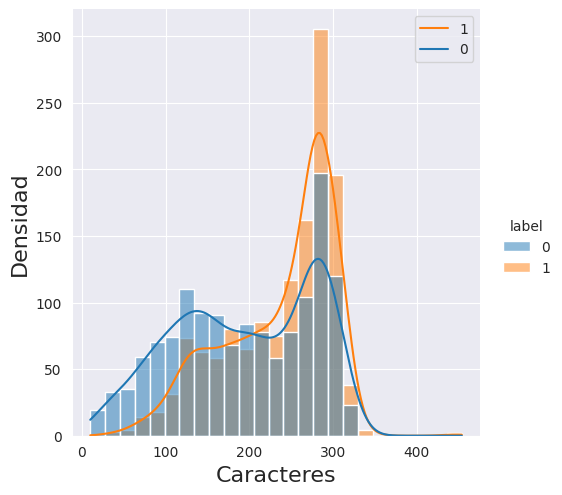

In [ ]:
# Importamos las librerías matplotlib y seaborn:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(14,12))
sns.set_style("darkgrid")

sns.displot(data=dataset_train_df, x="char_len", hue="label", kde=True, legend=True)
plt.legend(["1", "0"])
# Definimos el título de los ejes:
plt.xlabel('Caracteres', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

# Finalmente mostramos el gráfico:
plt.show()


Observamos que los tweets de la clase 0 suelen tener menores caracteres que la clase 1. Puede deberse a que cuando se hace mención a una profesión (clase 1) se está dando una opinión larga o de más detalle que cuando no se hace mención (clase 0), que pueden ser simplemente quejas por la situación del covid, más breves

**Análisis de contenido de los tweets**

Para ello utiliza wordclouds

In [ ]:
from wordcloud import WordCloud

In [ ]:
txt_cat0 = ",".join(dataset_train_df[dataset_train_df.label==0].text.to_list())
txt_cat1 = ",".join(dataset_train_df[dataset_train_df.label==1].text.to_list())

In [ ]:
from nltk.corpus import stopwords

en_stopwords = stopwords.words('spanish')

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=0,
                      contour_color='steelblue', stopwords=en_stopwords,
                      normalize_plurals = True)

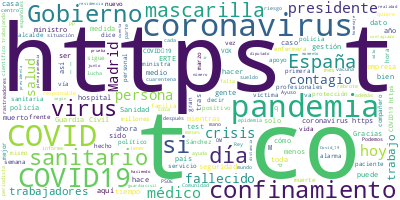

In [ ]:
# Genera el wordcloud
wordcloud.generate(txt_cat1)
# Visualizalo en una imagen
wordcloud.to_image()

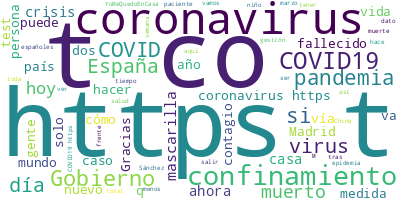

In [ ]:
# Genera el wordcloud
wordcloud.generate(txt_cat0)
# Visualizalo en una imagen
wordcloud.to_image()

Vemos muy bien la diferencia entre las clases. En los de la clase 1 aparecen menciones de profesiones:  médico, policía, presiedente, sanitario... Todas estas no aparecen (lógicamente) en las de la clase 0. También hay muchas comunes del tema que comparten: confinamiento, covid, virus, pandemia, etc

## Tokenización

Transformo cada dataset de pandas al formato que necesita HuggingFace para sus modelos, casteo la columna label a un clasificador con 2 clases distintas, y luego le cambio el nombre a 'labels' (leí que a veces daba problemas si no se llamaba así) y me aseguré de que fuera tipo entero

In [ ]:
from datasets import Dataset, DatasetDict, ClassLabel
dataset_train_hf = Dataset.from_pandas(dataset_train_df)
dataset_val_hf = Dataset.from_pandas(dataset_val_df)
dataset_test_hf = Dataset.from_pandas(dataset_test_df)

In [ ]:
dataset_train_hf = dataset_train_hf.cast_column("label", ClassLabel(num_classes=2))
dataset_val_hf = dataset_val_hf.cast_column("label", ClassLabel(num_classes=2))
dataset_test_hf = dataset_test_hf.cast_column("label", ClassLabel(num_classes=2))


Casting the dataset:   0%|          | 0/2786 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/999 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1001 [00:00<?, ? examples/s]

In [ ]:
def rename_label_to_labels(example):
    example['labels'] = int(example['label'])
    del example['label']
    return example

# Aplicar a cada dataset
dataset_train_hf = dataset_train_hf.map(rename_label_to_labels, batched=False)
dataset_val_hf = dataset_val_hf.map(rename_label_to_labels, batched=False)
dataset_test_hf = dataset_test_hf.map(rename_label_to_labels, batched=False)

Map:   0%|          | 0/2786 [00:00<?, ? examples/s]

Map:   0%|          | 0/999 [00:00<?, ? examples/s]

Map:   0%|          | 0/1001 [00:00<?, ? examples/s]

Importo las librerías necesarias para el modelado y el tokenizador

In [ ]:
# IMPORTS
from transformers import (
   AutoConfig,
   AutoTokenizer,
   AutoModelForSequenceClassification
)

Selecciona un modelo apropiado para la tarea:

Este ha sido el modelo que he elegido, buscando en huggingface (lenguaje: español, task:fill mask) Investigando, me decanté por BETO, el modelo BERT-base entrenado específicamente para español por la Universidad de Chile, disponible en HuggingFace como dccuchile/bert-base-spanish-wwm-uncased. Puede ser fine-tuneado sin problema, está entrenado completamente en español, tiene buen rendimiento con texto informal y tenía bastantes descargar en la plataforma (160k último mes)
Si bien es verdad que la primera vez intenté usar otro (pysentimento/robertuito-base-uncased) que parecía mejor opción ya que se entrenó también en español, pero se hizo sobre 500 millones de tweets que es justo lo que pide este problema. Pero a la hora de entrenar el modelo me daba errores, que no fui capaz de solucionar, por lo que usé la otra opción.

In [ ]:
#NO-MODIFY: VARIABLE NAME
model_name = "dccuchile/bert-base-spanish-wwm-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

Aquí aplico el tokenizado a cada dataset, con padding max length para que cada texto tenga la misma longitud en cada batch y truncation=true que corta los textos que no entren en la ventana de contexto del modelo

In [ ]:
tokenized_df_train = dataset_train_hf.map(
    lambda batch: tokenizer(batch["text"], padding='max_length', truncation=True),
    batched=True, batch_size=32
)
tokenized_df_val = dataset_val_hf.map(
    lambda batch: tokenizer(batch["text"], padding='max_length', truncation=True),
    batched=True, batch_size=32
)
tokenized_df_test = dataset_test_hf.map(
    lambda batch: tokenizer(batch["text"], padding='max_length', truncation=True),
    batched=True, batch_size=32
)

Map:   0%|          | 0/2786 [00:00<?, ? examples/s]

Map:   0%|          | 0/999 [00:00<?, ? examples/s]

Map:   0%|          | 0/1001 [00:00<?, ? examples/s]

## Fine-tuning

Cargo el modelo pre-entrenado con una cabeza de clasificación con 2 categorías

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Configuracion training_args

metric_for_best_model = f1 score (que es lo que se evaluará sobre test) y greater_is_better = true ( mientras más alto mejor)
learning_rate: Bajo. Ideal para datasets pequeños y procesos de fine-tuning

eval_strategy="steps": Se evalúa el modelo cada 50 pasos de entrenamiento, en lugar de al final de cada epoch

load_best_model_at_end=True: Al finalizar el entrenamiento, se carga automáticamente el modelo que haya obtenido la mejor puntuación en validación.

weight_decay: Se utiliza como técnica de regularización para evitar el sobreajuste (overfitting) penalizando grandes valores en los pesos del modelo.

logging_steps: Indica cada cuántos pasos se deben registrar las métricas de entrenamiento.



In [ ]:
#NO-MODIFY: VARIABLE NAME
training_args = TrainingArguments(
    output_dir="modelo_test",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.1,
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=50,
    logging_strategy="steps",
    logging_steps=50,
    load_best_model_at_end=True,
    push_to_hub=False,
    report_to="none",
    seed=52,
    metric_for_best_model="eval_f1_score",
    greater_is_better=True,

)


### Métricas de evaluación

Defino 3 métricas de evaluación: accuracy, f1 score y recall

In [ ]:

import numpy as np
import evaluate

accuracy = evaluate.load("accuracy")
f1_score = evaluate.load("f1")
recall_metric = evaluate.load("recall")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy_value = accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1_score_value = f1_score.compute(predictions=predictions, references=labels)["f1"]
    recall_value = recall_metric.compute(predictions=predictions, references=labels)["recall"]

    return {
        "accuracy": accuracy_value,
        "f1_score": f1_score_value,
        "recall": recall_value,
    }



### Ajuste del modelo

Lleva a cabo el ajuste del modelo:

Configuro la clase trainer, añadiendo el modelo preentrenado, los train args ya definidos, los conjuntos de test y evaluación, el tokenizador, las métricas y por último he decidido añadir un Early Stopping basándome en el f1 score (configurado previamente en los training args) para que el modelo deje de entrenar cuando el f1 score deje de mejorar (patience= 5)

In [ ]:
from transformers import EarlyStoppingCallback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_df_train,
    eval_dataset=tokenized_df_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]

)

/tmp/ipython-input-1036128563.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Entreno el modelo y veo que para antes del epoch 2 gracias al Early Stopping, con unas métricas bastante decentes

In [ ]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss,Validation Loss,Accuracy,F1 Score,Recall
50,0.157800,1.043954,0.764765,0.653903,0.932773
100,0.162200,0.707906,0.827828,0.713333,0.899160
150,0.144300,0.459554,0.912913,0.827038,0.873950
200,0.116700,0.528141,0.886887,0.789572,0.890756
250,0.108000,0.561618,0.886887,0.794918,0.920168
300,0.066700,0.516087,0.908909,0.820513,0.873950
350,0.119300,0.352898,0.929930,0.850427,0.836134
400,0.024500,0.553842,0.902903,0.809430,0.865546
450,0.032600,0.657604,0.896897,0.806754,0.903361
500,0.015900,0.911146,0.865866,0.764912,0.915966


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packa

TrainOutput(global_step=600, training_loss=0.10078818331162134, metrics={'train_runtime': 819.5235, 'train_samples_per_second': 13.598, 'train_steps_per_second': 1.703, 'total_flos': 1261354399395840.0, 'train_loss': 0.10078818331162134, 'epoch': 1.7191977077363898})

## Evaluacion

Realizo la evaluación sobre el conjunto de validación ya que sobre el de test no se puede (no tenemos las labels). Obtenemos buenos resultados: f1 score de 0.83, accuracy 0.92...

In [ ]:
trainer.evaluate(tokenized_df_val)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'eval_loss': 0.47744789719581604,
 'eval_accuracy': 0.918918918918919,
 'eval_f1_score': 0.8336755646817249,
 'eval_recall': 0.8529411764705882,
 'eval_runtime': 30.6117,
 'eval_samples_per_second': 32.635,
 'eval_steps_per_second': 4.083,
 'epoch': 1.7191977077363898}

## Genera predicciones

In [ ]:
tokenized_df_test["labels"][0:4]

[-1, -1, -1, -1]

Corrijo las labels del test que son -1 para que el .predict pueda funcionar correctamente y genere mis predicciones sobre los documentos del conjunto test

In [ ]:
def fix_labels(example):
    example["labels"] = 1  # O lo que toque
    return example
ClassLabel
# Aplica la función al dataset de evaluación
dataset_test = tokenized_df_test.map(fix_labels)

Map:   0%|          | 0/1001 [00:00<?, ? examples/s]

In [ ]:
dataset_test["labels"][0:4]

[1, 1, 1, 1]

In [ ]:
predictions = trainer.predict(dataset_test)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Hago las predicciones (0 o 1) y las guardo en un dataframe de pandas asociando cada tweet id a su label predicha, para exportartlo como tsv

In [ ]:
y_pred = predictions.predictions.argmax(axis=1)
x_id = [x["tweet_id"] for x in dataset_test]

In [ ]:
import pandas as pd
output_df = pd.DataFrame(
    {'id': x_id,
     'label': y_pred
    })

In [ ]:
output_df.head(10)

,id,label
0,1277969650051997701,1
1,1263161378627600385,0
2,1255919996779315208,0
3,1282361712117780486,0
4,1267872916009615364,0
5,1286821839461851138,1
6,1242831505539444739,0
7,1245273112305971200,0
8,1250159489598324744,0
9,1283375865003474944,0


In [ ]:
output_df.to_csv("MORALA_GOLLINGS_PABLO_ejercicio1_predicciones.tsv", sep="\t",index=False)

Comparo el .head anterior con el .head siguiente para ver los tweet_id, su texto y su predicted label. Para estos 10 ejemplos parece estar funcionando perfecto, aquellos text que mencionan profesiones (por ejemplo el primero, dice limpiadora) los clasifica como 1 y los que no mencionan profesiones (p.ej el segundo, que no menciona ninguna profesión), lo clasifica como 0. El modelo parece estar funcionando bien en sus predicciones

In [ ]:
import pandas as pd

# Configura pandas para mostrar la longitud completa del texto en cada celda
pd.set_option('display.max_colwidth', None)

df = pd.DataFrame(dataset_test.select_columns(['tweet_id', 'text']))
print(df.head(10))


              tweet_id  \
0  1277969650051997701   
1  1263161378627600385   
2  1255919996779315208   
3  1282361712117780486   
4  1267872916009615364   
5  1286821839461851138   
6  1242831505539444739   
7  1245273112305971200   
8  1250159489598324744   
9  1283375865003474944   

                                                                                                                                                                                                                                                                                           text  
0    Esto es vergonzoso : una limpiadora de un hospital ha sido sancionada con 10 días sin sueldo por llamar la atención de altos cargos del centro que no usaban mascarillas . La limpiadora trabaja para la empresa Cecle , de Florentino Pérez . Piara de caciques . https://t.co/q50kHEMgZo  
1                                                                                                                           @el_pais 